# Grammar Learner 0.3: clustering disjuncts `2018-04-12`
Update of previous [http://88.99.210.144/data/clustering_2018/html/Grammar-Learner-2-2018-04-06.html](http://88.99.210.144/data/clustering_2018/html/Grammar-Learner-2-2018-04-06.html)

**TL;DR**:
- Separate category learning and grammar learning;
- **Category Learner update**: clustering option: grouping identical contexts (former "Identical Lexical Entries" branch;
- **Grammar Learner**: Link Grammar rules based on connector sets ("relaxed rules") or disjunct sets ("strict rules");
- Test results: [http://88.99.210.144/data/clustering_2018/Grammar-Learner-3-2018-04-12/](http://88.99.210.144/data/clustering_2018/Grammar-Learner-3-2018-04-12/)

- Batch tests on real data from OpenCog MST parser: 
 - ["POC-Turtle" corpus](http://88.99.210.144/data/clustering_2018/AGI-2018/POC-Turtle/),  
 - ["POC-English-NoAmb" corpus](http://88.99.210.144/data/clustering_2018/AGI-2018/POC-English-NoAmb/).  

A static html copy of this notebook is shared via  
[http://88.99.210.144/data/clustering_2018/html/Grammar-Learner-3-2018-04-12.html](http://88.99.210.144/data/clustering_2018/html/Grammar-Learner-3-2018-04-12.html)

## Introduction

In [1]:
import os, sys, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path: sys.path.append(module_path)
from src.utl.utl import UTC
from src.utl.read_files import check_dir
print(UTC(), module_path)
prefix = '' # unised option: every project output file will start with this prefix
tmpath = module_path + '/tmp/'
check_dir(tmpath, True, 'none')
from src.grammar_learner.poc03 import learn_grammar

2018-04-14 16:02:40 UTC /home/oleg/language-learning


Grammar Learner specification in [Unsupervised Language Learning (ULL) Design (DRAFT)](https://docs.google.com/document/d/14MpKLH5_5eVI39PRZuWLZHa1aUS73pJZNZzgigCWwWg/edit#bookmark=id.rtsrh3l8jgj3):
- Input
  - Directory to read parse files (1 to many input files)
  - Path to store learned categories
  - Path to store learned dictionary Link Grammar file
- Settings
  - Parse_mode, as one of the following
    - given - use all links as given (default)
    - exploded - explode all possible combinations of links given the sentence
  - learn_mode, as one of the following 
    - lexical_entries (default)
    - connectors_only
    - connectors_and_disjuncts (will have to see if it is possible - TODO)
  - TODO - else?
- Output
  - File with learned categories
  - File with learned grammar
  
_Settings amendments are suggested in the next section_

## Settings, parameters, data

In [2]:
# Directory to read parse files (1 to many input files)
#-input_dir = module_path + '/data/POC_English_NoAmb/mst_fixed_manually/'
#-input_dir = module_path + '/data/POC_Turtle/MST_fixed_manually/'
# Paths to store learned categories, learned dictionary Link Grammar file
# batch_dir = module_path + '/output/POC_Turtle-2018-04-11/'    # Done 80411 ~OK
#-batch_dir = module_path + '/output/POC_Turtle-2018-04-12/'      # Cleanup
prj_dir = batch_dir + 'MST_fixed_manually/disjuncts-DRK-disjuncts/'
if check_dir(prj_dir, create=True, verbose='max'):
    cat_path = prj_dir  # Path to store learned categories
    dict_path = prj_dir # Path to store learned dictionary Link Grammar file
# The following test sample results are stored in separate directories specifies for each sample.

# Settings:
parse_mode = 'given'            # 'given' (default) / 'explosive' (next)
left_wall = 'LEFT-WALL'         # '','none' - don't use / 
                                # 'string' - replace ###LEFT-WALL### with the string
period = True                   # use period in links learning: True/False

#-learn_mode = 'connectors_only'  # ~ context = 1, window = 'mst', weighting = 'ppmi'
#-learn_mode = 'lexical_entries'  # ~ context = 2, group = True, 
# learn_mode decomposed:
#context = 1                     # 1: connectors / 0: 'words' /
context = 2                     # 2,3...: disjuncts with limited number of links
window = 'mst'                  # 'mst' / reserved options for «explosive» parsing
weighting = 'ppmi'              # 'ppmi' / future options
group = True                    # group items after link parsing, sum counts 

#+distance = False?
    
word_space = 'vectors'          # 'vectors' / 'discrete' - no dimensionality reduction
dim_max = 100                   # max vector space dimensionality
sv_min = 0.1                    # minimal singular value (fraction of the max value)
dim_reduction = 'svm'           # 'svm' / 'none' (discrete word_space, group)

#word_space = 'discrete'         # 80411 Turtle grouping test 
#dim_reduction = 'none'          # 80411 Turtle grouping test 
#clustering = 'group'            # 80411 Turtle grouping test 

clustering = 'kmeans'           # 'kmeans' / 'group'~'identical_entries' / future options
cluster_range = (2,48,1)        # min, max, step
cluster_criteria = 'silhouette'
cluster_level = 0.9             # level = 0, 1, 0.-0.99..: 0 - max number of clusters

generalization = 'off'          # 'off' / future options: 'cosine', ...
merge = 0.8                     # merge clusters with similarity > this 'merge' criteria
aggregate = 0.2                 # agglomerate clusters with similarity > this criteria

grammar_rules = 2               # 1: 'connectors' / 2 - 'disjuncts' / 0 - 'words' (TODO?)

verbose='mid'   # display intermediate results: 'none', 'min', 'mid', 'max'

Directory /home/oleg/language-learning/output/POC_Turtle-2018-04-12/MST_fixed_manually/disjuncts-DRK-disjuncts/ exists.


# POC-Turtle, "MST fixed manually" corpus

In [3]:
batch_dir = module_path + \
    '/output/Grammar-Learner-3-2018-04-12/POC_Turtle/'

## Disjuncts - DRK* - disjuncts
`*DRK: dimension reduction (SVM) and K-means clustering`

Directory /home/oleg/language-learning/output/Grammar-Learner-3-2018-04-12/POC_Turtle/MST_fixed_manually/disjuncts-DRK-disjuncts/ created.
15 unique words and 29 unique links form 44 unique word-link pairs from 60 parsed items


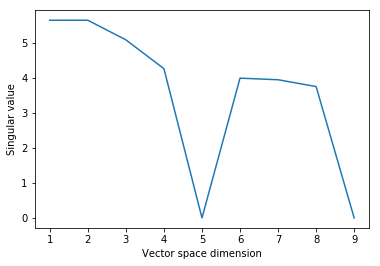

Vector space dimensionality = 8
Singular value (8) = 3.7
Max singular value (1) = 5.6
Singular value (8) = 3.7385588793217883e-10
Silhouette index in a range of cluster numbers


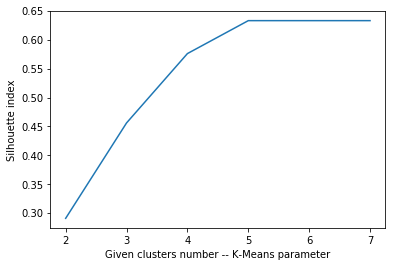

Optimal number of clusters: 4
Cluster words in vector space, axes 1 and 3


Parent,Category,Quality,Words,Relevance
C00,C01,0.0,"['.', 'LEFT-WALL', 'has', 'isa']","[0, 0, 0, 0]"
C00,C02,0.0,"['feather', 'fin', 'scale', 'wing']","[0, 0, 0, 0]"
C00,C03,0.0,"['eagle', 'herring', 'parrot', 'tuna']","[0, 0, 0, 0]"
C00,C04,0.0,"['bird', 'extremity', 'fish']","[0, 0, 0]"



Category list - 4 lines, saved to /home/oleg/language-learning/output/Grammar-Learner-3-2018-04-12/POC_Turtle/MST_fixed_manually/disjuncts-DRK-disjuncts/categories.txt


Cluster,Germs,L,R,Disjuncts
C01,"['.', 'LEFT-WALL', 'has', 'isa']",[],[],"['C02C01-', 'C04C01-', 'C01C02+', 'C01C03+', 'C02C01- & C01C02+', 'C03C01- & C01C02+', 'C03C01- & C01C04+', 'C02C01- & C01C04+']"
C02,"['feather', 'fin', 'scale', 'wing']",[],[],"['C01C02- & C02C01+', 'C01C02- & C02C01+', 'C01C02- & C02C01+', 'C01C02- & C02C01+']"
C03,"['eagle', 'herring', 'parrot', 'tuna']",[],[],"['C01C03- & C03C01+', 'C01C03- & C03C01+', 'C01C03- & C03C01+', 'C01C03- & C03C01+']"
C04,"['bird', 'extremity', 'fish']",[],[],"['C01C04- & C04C01+', 'C01C04- & C04C01+', 'C01C04- & C04C01+']"


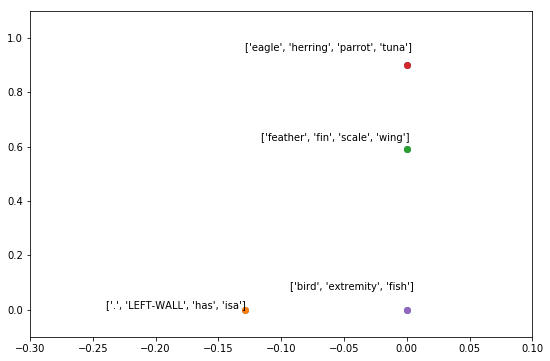

In [4]:
context = 2                     # 2+: 'dusjuncts' / 1: connectors
word_space = 'vectors'          # 'vectors' / 'discrete' - no dimensionality reduction
dim_max = 100                   # max vector space dimensionality
sv_min = 0.1                    # minimal singular value (fraction of the max value)
dim_reduction = 'svm'           # 'svm' / 'none' (discrete word_space, group)
clustering = 'kmeans'           #
grammar_rules = 2               # 1: connectors / 2+: 'dusjuncts'
verbose = 'mid'

input_dir = module_path + '/data/POC_Turtle/MST_fixed_manually/'
# Paths to store learned categories, learned dictionary Link Grammar file
prj_dir = batch_dir + 'MST_fixed_manually/disjuncts-DRK-disjuncts/'
if check_dir(prj_dir, create=True, verbose='max'):
    cat_path = prj_dir  # Path to store learned categories
    dict_path = prj_dir # Path to store learned dictionary Link Grammar file

lg_rules_str = learn_grammar(input_dir, cat_path, dict_path, tmpath, verbose, \
    parse_mode, left_wall, period, context, window, weighting, group, \
    word_space, dim_max, sv_min, dim_reduction, \
    clustering, cluster_range, cluster_criteria, cluster_level,
    generalization, merge, aggregate, grammar_rules)

## Connectors - DRK - disjuncts

Directory /home/oleg/language-learning/output/Grammar-Learner-3-2018-04-12/POC_Turtle/MST_fixed_manually/connectors-DRK-disjuncts/ created.
15 unique words and 28 unique links form 64 unique word-link pairs from 64 parsed items


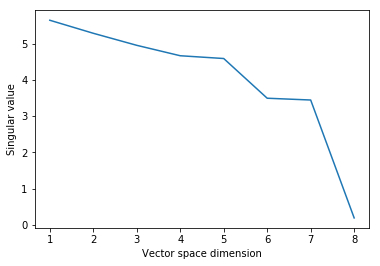

Vector space dimensionality = 7
Singular value (7) = 3.4
Max singular value (1) = 5.6
Singular value (7) = 0.19275911971807783
Silhouette index in a range of cluster numbers


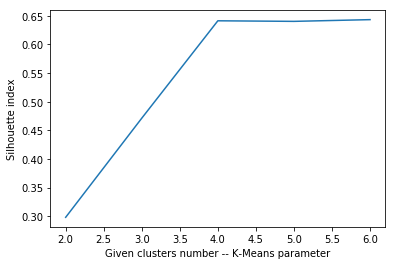

Optimal number of clusters: 4
Cluster words in vector space, axes 1 and 2


Parent,Category,Quality,Words,Relevance
C00,C01,0.0,"['.', 'LEFT-WALL', 'has', 'isa']","[0, 0, 0, 0]"
C00,C02,0.0,"['bird', 'extremity', 'fish']","[0, 0, 0]"
C00,C03,0.0,"['feather', 'fin', 'scale', 'wing']","[0, 0, 0, 0]"
C00,C04,0.0,"['eagle', 'herring', 'parrot', 'tuna']","[0, 0, 0, 0]"



Category list - 4 lines, saved to /home/oleg/language-learning/output/Grammar-Learner-3-2018-04-12/POC_Turtle/MST_fixed_manually/connectors-DRK-disjuncts/categories.txt
15 unique words and 28 unique links form 64 unique word-link pairs from 64 parsed items


Cluster,Germs,L,R,Disjuncts
C01,"['.', 'LEFT-WALL', 'has', 'isa']",[],[],"['C02C01-', 'C03C01-', 'C01C04+', 'C01C03+', 'C03C01-', 'C04C01-', 'C01C03+', 'C01C02+', 'C03C01-', 'C04C01-']"
C02,"['bird', 'extremity', 'fish']",[],[],"['C01C02-', 'C02C01+', 'C01C02-', 'C02C01+', 'C01C02-', 'C02C01+']"
C03,"['feather', 'fin', 'scale', 'wing']",[],[],"['C01C03-', 'C03C01+', 'C01C03-', 'C03C01+', 'C01C03-', 'C03C01+', 'C01C03-', 'C03C01+']"
C04,"['eagle', 'herring', 'parrot', 'tuna']",[],[],"['C01C04-', 'C04C01+', 'C01C04-', 'C04C01+', 'C01C04-', 'C04C01+', 'C01C04-', 'C04C01+']"


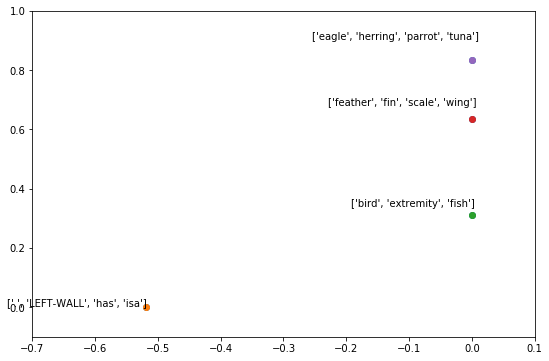

In [5]:
context = 1
verbose = 'mid'

prj_dir = batch_dir + 'MST_fixed_manually/connectors-DRK-disjuncts/'
if check_dir(prj_dir, create=True, verbose='max'):
    cat_path = prj_dir  # Path to store learned categories
    dict_path = prj_dir # Path to store learned dictionary Link Grammar file

lg_rules_str = learn_grammar(input_dir, cat_path, dict_path, tmpath, verbose, \
    parse_mode, left_wall, period, context, window, weighting, group, \
    word_space, dim_max, sv_min, dim_reduction, \
    clustering, cluster_range, cluster_criteria, cluster_level,
    generalization, merge, aggregate, grammar_rules)

## Disjuncts - ILE** - disjuncts
`**ILE - Grouping identical lexical entries`

In [6]:
context = 2             # 1: connectors / 2+: 'dusjuncts'
word_space = 'discrete'
dim_reduction = 'none' 
clustering = 'group'   
grammar_rules = 2       # 1: connectors / 2+: 'dusjuncts'
verbose = 'mid'

# Paths to store learned categories, learned dictionary Link Grammar file
prj_dir = batch_dir + '/MST_fixed_manually/disjuncts-ILE-disjuncts/'
if check_dir(prj_dir, create=True, verbose='max'):
    cat_path = prj_dir  # Path to store learned categories
    dict_path = prj_dir # Path to store learned dictionary Link Grammar file

lg_rules_str = learn_grammar(input_dir, cat_path, dict_path, tmpath, verbose, \
    parse_mode, left_wall, period, context, window, weighting, group, \
    word_space, dim_max, sv_min, dim_reduction, \
    clustering, cluster_range, cluster_criteria, cluster_level,
    generalization, merge, aggregate, grammar_rules)

print('\nLink Grammar rules:\n')
for line in lg_rules_str.splitlines(): print(line)

Directory /home/oleg/language-learning/output/Grammar-Learner-3-2018-04-12/POC_Turtle//MST_fixed_manually/disjuncts-ILE-disjuncts/ created.
15 unique words and 29 unique links form 44 unique word-link pairs from 60 parsed items
Total 8 clusters of identical lexical entries <class 'pandas.core.frame.DataFrame'>


Parent,Category,Quality,Words,Relevance
C00,C01,0.0,['.'],[0]
C00,C02,0.0,['LEFT-WALL'],[0]
C00,C03,0.0,"['bird', 'extremity', 'fish']","[0, 0, 0]"
C00,C04,0.0,"['eagle', 'herring', 'parrot', 'tuna']","[0, 0, 0, 0]"
C00,C05,0.0,"['feather', 'scale']","[0, 0]"
C00,C06,0.0,"['fin', 'wing']","[0, 0]"
C00,C07,0.0,['has'],[0]
C00,C08,0.0,['isa'],[0]



Category list - 8 lines, saved to /home/oleg/language-learning/output/Grammar-Learner-3-2018-04-12/POC_Turtle//MST_fixed_manually/disjuncts-ILE-disjuncts/categories.txt


Cluster,Germs,L,R,Disjuncts
C01,['.'],[],[],"['C06C01-', 'C05C01-', 'C03C01-']"
C02,['LEFT-WALL'],[],[],"['C02C04+', 'C02C06+']"
C03,"['bird', 'extremity', 'fish']",[],[],"['C08C03- & C03C01+', 'C08C03- & C03C01+', 'C08C03- & C03C01+']"
C04,"['eagle', 'herring', 'parrot', 'tuna']",[],[],"['C02C04- & C04C07+', 'C02C04- & C04C08+', 'C02C04- & C04C07+', 'C02C04- & C04C08+', 'C02C04- & C04C07+', 'C02C04- & C04C08+', 'C02C04- & C04C07+', 'C02C04- & C04C08+']"
C05,"['feather', 'scale']",[],[],"['C07C05- & C05C01+', 'C07C05- & C05C01+']"
C06,"['fin', 'wing']",[],[],"['C07C06- & C06C01+', 'C02C06- & C06C07+', 'C02C06- & C06C08+', 'C07C06- & C06C01+', 'C02C06- & C06C07+', 'C02C06- & C06C08+']"
C07,['has'],[],[],"['C04C07- & C07C06+', 'C06C07- & C07C05+']"
C08,['isa'],[],[],"['C06C08- & C08C03+', 'C04C08- & C08C03+']"



Link Grammar rules:

% POC English Link Grammar v.0.7 2018-04-14 16:02:42 UTC
<dictionary-version-number>: V0v0v7+;
<dictionary-locale>: EN4us+;

% C01
".":
(C06C01-) or (C05C01-) or (C03C01-);

% C02
"LEFT-WALL":
(C02C04+) or (C02C06+);

% C03
"bird" "extremity" "fish":
(C08C03- & C03C01+) or (C08C03- & C03C01+) or (C08C03- & C03C01+);

% C04
"eagle" "herring" "parrot" "tuna":
(C02C04- & C04C07+) or (C02C04- & C04C08+) or (C02C04- & C04C07+) or (C02C04- & C04C08+) or (C02C04- & C04C07+) or (C02C04- & C04C08+) or (C02C04- & C04C07+) or (C02C04- & C04C08+);

% C05
"feather" "scale":
(C07C05- & C05C01+) or (C07C05- & C05C01+);

% C06
"fin" "wing":
(C07C06- & C06C01+) or (C02C06- & C06C07+) or (C02C06- & C06C08+) or (C07C06- & C06C01+) or (C02C06- & C06C07+) or (C02C06- & C06C08+);

% C07
"has":
(C04C07- & C07C06+) or (C06C07- & C07C05+);

% C08
"isa":
(C06C08- & C08C03+) or (C04C08- & C08C03+);

UNKNOWN-WORD: XXX+;

% 8 word clusters, 8 Link Grammar rules.
% Link Grammar file saved to: 

## Disjuncts - ILE - connectors

In [7]:
grammar_rules = 2       # 1: connectors / 2+: dusjuncts
verbose = 'min'

# Paths to store learned categories, learned dictionary Link Grammar file
prj_dir = batch_dir + '/MST_fixed_manually/disjuncts-ILE-connectors/'
if check_dir(prj_dir, create=True, verbose='max'):
    cat_path = prj_dir  # Path to store learned categories
    dict_path = prj_dir # Path to store learned dictionary Link Grammar file

lg_rules_str = learn_grammar(input_dir, cat_path, dict_path, tmpath, verbose, \
    parse_mode, left_wall, period, context, window, weighting, group, \
    word_space, dim_max, sv_min, dim_reduction, \
    clustering, cluster_range, cluster_criteria, cluster_level,
    generalization, merge, aggregate, grammar_rules)

print('\nLink Grammar rules:\n')
for line in lg_rules_str.splitlines(): print(line)

Directory /home/oleg/language-learning/output/Grammar-Learner-3-2018-04-12/POC_Turtle//MST_fixed_manually/disjuncts-ILE-connectors/ created.

Link Grammar rules:

% POC English Link Grammar v.0.7 2018-04-14 16:02:42 UTC
<dictionary-version-number>: V0v0v7+;
<dictionary-locale>: EN4us+;

% C01
".":
(C06C01-) or (C05C01-) or (C03C01-);

% C02
"LEFT-WALL":
(C02C04+) or (C02C06+);

% C03
"bird" "extremity" "fish":
(C08C03- & C03C01+) or (C08C03- & C03C01+) or (C08C03- & C03C01+);

% C04
"eagle" "herring" "parrot" "tuna":
(C02C04- & C04C07+) or (C02C04- & C04C08+) or (C02C04- & C04C07+) or (C02C04- & C04C08+) or (C02C04- & C04C07+) or (C02C04- & C04C08+) or (C02C04- & C04C07+) or (C02C04- & C04C08+);

% C05
"feather" "scale":
(C07C05- & C05C01+) or (C07C05- & C05C01+);

% C06
"fin" "wing":
(C07C06- & C06C01+) or (C02C06- & C06C07+) or (C02C06- & C06C08+) or (C07C06- & C06C01+) or (C02C06- & C06C07+) or (C02C06- & C06C08+);

% C07
"has":
(C04C07- & C07C06+) or (C06C07- & C07C05+);

% C08
"is

# POC-English-NoAmb MST-fixed corpus

In [10]:
input_dir = module_path + '/data/POC_English_NoAmb/mst_fixed_manually/'
batch_dir = module_path + \
    '/output/Grammar-Learner-3-2018-04-12/POC_English_NoAmb/'

## Disjuncts - DRK - disjuncts

Directory /home/oleg/language-learning/output/Grammar-Learner-3-2018-04-12/POC_English_NoAmb/MST_fixed_manually/disjuncts-DRK-disjuncts/ created.
15 unique words and 29 unique links form 44 unique word-link pairs from 60 parsed items


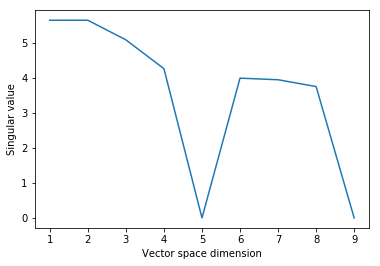

Vector space dimensionality = 8
Singular value (8) = 3.7
Max singular value (1) = 5.6
Singular value (8) = 3.7385588793217883e-10
Silhouette index in a range of cluster numbers


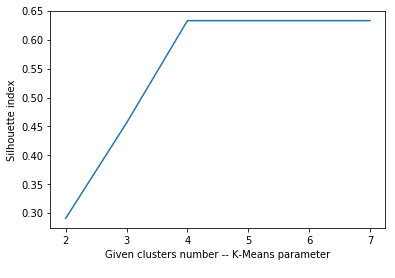

Optimal number of clusters: 4
Cluster words in vector space, axes 1 and 3


Parent,Category,Quality,Words,Relevance
C00,C01,0.0,"['.', 'LEFT-WALL', 'has', 'isa']","[0, 0, 0, 0]"
C00,C02,0.0,"['feather', 'fin', 'scale', 'wing']","[0, 0, 0, 0]"
C00,C03,0.0,"['eagle', 'herring', 'parrot', 'tuna']","[0, 0, 0, 0]"
C00,C04,0.0,"['bird', 'extremity', 'fish']","[0, 0, 0]"



Category list - 4 lines, saved to /home/oleg/language-learning/output/Grammar-Learner-3-2018-04-12/POC_English_NoAmb/MST_fixed_manually/disjuncts-DRK-disjuncts/categories.txt


Cluster,Germs,L,R,Disjuncts
C01,"['.', 'LEFT-WALL', 'has', 'isa']",[],[],"['C02C01-', 'C04C01-', 'C01C02+', 'C01C03+', 'C02C01- & C01C02+', 'C03C01- & C01C02+', 'C03C01- & C01C04+', 'C02C01- & C01C04+']"
C02,"['feather', 'fin', 'scale', 'wing']",[],[],"['C01C02- & C02C01+', 'C01C02- & C02C01+', 'C01C02- & C02C01+', 'C01C02- & C02C01+']"
C03,"['eagle', 'herring', 'parrot', 'tuna']",[],[],"['C01C03- & C03C01+', 'C01C03- & C03C01+', 'C01C03- & C03C01+', 'C01C03- & C03C01+']"
C04,"['bird', 'extremity', 'fish']",[],[],"['C01C04- & C04C01+', 'C01C04- & C04C01+', 'C01C04- & C04C01+']"


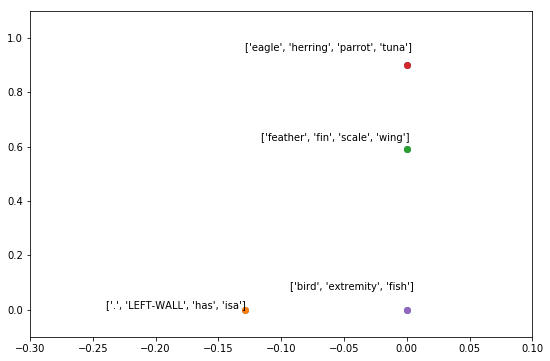

In [11]:
context = 2                     # 2+: 'dusjuncts' / 1: connectors
word_space = 'vectors'          # 'vectors' / 'discrete' - no dimensionality reduction
dim_max = 100                   # max vector space dimensionality
sv_min = 0.1                    # minimal singular value (fraction of the max value)
dim_reduction = 'svm'           # 'svm' / 'none' (discrete word_space, group)
clustering = 'kmeans'           #
grammar_rules = 2               # 1: connectors / 2+: 'dusjuncts'
verbose = 'mid'

input_dir = module_path + '/data/POC_Turtle/MST_fixed_manually/'
# Paths to store learned categories, learned dictionary Link Grammar file
prj_dir = batch_dir + 'MST_fixed_manually/disjuncts-DRK-disjuncts/'
if check_dir(prj_dir, create=True, verbose='max'):
    cat_path = prj_dir  # Path to store learned categories
    dict_path = prj_dir # Path to store learned dictionary Link Grammar file

lg_rules_str = learn_grammar(input_dir, cat_path, dict_path, tmpath, verbose, \
    parse_mode, left_wall, period, context, window, weighting, group, \
    word_space, dim_max, sv_min, dim_reduction, \
    clustering, cluster_range, cluster_criteria, cluster_level,
    generalization, merge, aggregate, grammar_rules)

## Connectors - DRK - disjuncts

Directory /home/oleg/language-learning/output/Grammar-Learner-3-2018-04-12/POC_English_NoAmb/MST_fixed_manually/connectors-DRK-disjuncts/ created.
15 unique words and 28 unique links form 64 unique word-link pairs from 64 parsed items


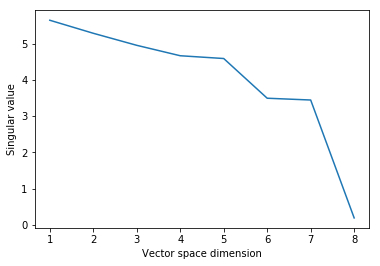

Vector space dimensionality = 7
Singular value (7) = 3.4
Max singular value (1) = 5.6
Singular value (7) = 0.19275911971807783
Silhouette index in a range of cluster numbers


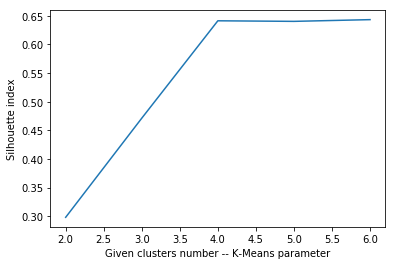

Optimal number of clusters: 4
Cluster words in vector space, axes 1 and 2


Parent,Category,Quality,Words,Relevance
C00,C01,0.0,"['.', 'LEFT-WALL', 'has', 'isa']","[0, 0, 0, 0]"
C00,C02,0.0,"['bird', 'extremity', 'fish']","[0, 0, 0]"
C00,C03,0.0,"['feather', 'fin', 'scale', 'wing']","[0, 0, 0, 0]"
C00,C04,0.0,"['eagle', 'herring', 'parrot', 'tuna']","[0, 0, 0, 0]"



Category list - 4 lines, saved to /home/oleg/language-learning/output/Grammar-Learner-3-2018-04-12/POC_English_NoAmb/MST_fixed_manually/connectors-DRK-disjuncts/categories.txt
15 unique words and 28 unique links form 64 unique word-link pairs from 64 parsed items


Cluster,Germs,L,R,Disjuncts
C01,"['.', 'LEFT-WALL', 'has', 'isa']",[],[],"['C02C01-', 'C03C01-', 'C01C04+', 'C01C03+', 'C03C01-', 'C04C01-', 'C01C03+', 'C01C02+', 'C03C01-', 'C04C01-']"
C02,"['bird', 'extremity', 'fish']",[],[],"['C01C02-', 'C02C01+', 'C01C02-', 'C02C01+', 'C01C02-', 'C02C01+']"
C03,"['feather', 'fin', 'scale', 'wing']",[],[],"['C01C03-', 'C03C01+', 'C01C03-', 'C03C01+', 'C01C03-', 'C03C01+', 'C01C03-', 'C03C01+']"
C04,"['eagle', 'herring', 'parrot', 'tuna']",[],[],"['C01C04-', 'C04C01+', 'C01C04-', 'C04C01+', 'C01C04-', 'C04C01+', 'C01C04-', 'C04C01+']"


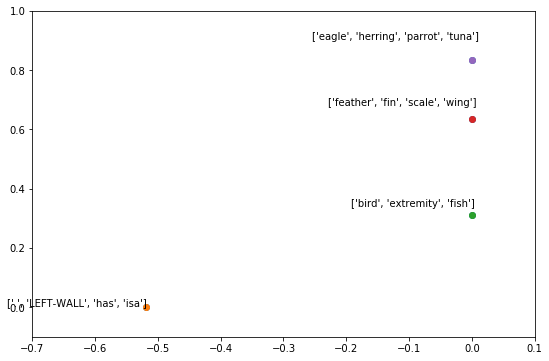

In [12]:
context = 1
verbose = 'mid'

prj_dir = batch_dir + 'MST_fixed_manually/connectors-DRK-disjuncts/'
if check_dir(prj_dir, create=True, verbose='max'):
    cat_path = prj_dir  # Path to store learned categories
    dict_path = prj_dir # Path to store learned dictionary Link Grammar file

lg_rules_str = learn_grammar(input_dir, cat_path, dict_path, tmpath, verbose, \
    parse_mode, left_wall, period, context, window, weighting, group, \
    word_space, dim_max, sv_min, dim_reduction, \
    clustering, cluster_range, cluster_criteria, cluster_level,
    generalization, merge, aggregate, grammar_rules)

## Disjuncts - ILE - disjuncts

In [13]:
context = 2             # 1: connectors / 2+: 'dusjuncts'
word_space = 'discrete'
dim_reduction = 'none' 
clustering = 'group'   
grammar_rules = 2       # 1: connectors / 2+: 'dusjuncts'
verbose = 'mid'

# Paths to store learned categories, learned dictionary Link Grammar file
prj_dir = batch_dir + '/MST_fixed_manually/disjuncts-ILE-disjuncts/'
if check_dir(prj_dir, create=True, verbose='max'):
    cat_path = prj_dir  # Path to store learned categories
    dict_path = prj_dir # Path to store learned dictionary Link Grammar file

lg_rules_str = learn_grammar(input_dir, cat_path, dict_path, tmpath, verbose, \
    parse_mode, left_wall, period, context, window, weighting, group, \
    word_space, dim_max, sv_min, dim_reduction, \
    clustering, cluster_range, cluster_criteria, cluster_level,
    generalization, merge, aggregate, grammar_rules)

print('\nLink Grammar rules:\n')
for line in lg_rules_str.splitlines(): print(line)

Directory /home/oleg/language-learning/output/Grammar-Learner-3-2018-04-12/POC_English_NoAmb//MST_fixed_manually/disjuncts-ILE-disjuncts/ created.
15 unique words and 29 unique links form 44 unique word-link pairs from 60 parsed items
Total 8 clusters of identical lexical entries <class 'pandas.core.frame.DataFrame'>


Parent,Category,Quality,Words,Relevance
C00,C01,0.0,['.'],[0]
C00,C02,0.0,['LEFT-WALL'],[0]
C00,C03,0.0,"['bird', 'extremity', 'fish']","[0, 0, 0]"
C00,C04,0.0,"['eagle', 'herring', 'parrot', 'tuna']","[0, 0, 0, 0]"
C00,C05,0.0,"['feather', 'scale']","[0, 0]"
C00,C06,0.0,"['fin', 'wing']","[0, 0]"
C00,C07,0.0,['has'],[0]
C00,C08,0.0,['isa'],[0]



Category list - 8 lines, saved to /home/oleg/language-learning/output/Grammar-Learner-3-2018-04-12/POC_English_NoAmb//MST_fixed_manually/disjuncts-ILE-disjuncts/categories.txt


Cluster,Germs,L,R,Disjuncts
C01,['.'],[],[],"['C06C01-', 'C05C01-', 'C03C01-']"
C02,['LEFT-WALL'],[],[],"['C02C04+', 'C02C06+']"
C03,"['bird', 'extremity', 'fish']",[],[],"['C08C03- & C03C01+', 'C08C03- & C03C01+', 'C08C03- & C03C01+']"
C04,"['eagle', 'herring', 'parrot', 'tuna']",[],[],"['C02C04- & C04C07+', 'C02C04- & C04C08+', 'C02C04- & C04C07+', 'C02C04- & C04C08+', 'C02C04- & C04C07+', 'C02C04- & C04C08+', 'C02C04- & C04C07+', 'C02C04- & C04C08+']"
C05,"['feather', 'scale']",[],[],"['C07C05- & C05C01+', 'C07C05- & C05C01+']"
C06,"['fin', 'wing']",[],[],"['C07C06- & C06C01+', 'C02C06- & C06C07+', 'C02C06- & C06C08+', 'C07C06- & C06C01+', 'C02C06- & C06C07+', 'C02C06- & C06C08+']"
C07,['has'],[],[],"['C04C07- & C07C06+', 'C06C07- & C07C05+']"
C08,['isa'],[],[],"['C06C08- & C08C03+', 'C04C08- & C08C03+']"



Link Grammar rules:

% POC English Link Grammar v.0.7 2018-04-14 16:03:40 UTC
<dictionary-version-number>: V0v0v7+;
<dictionary-locale>: EN4us+;

% C01
".":
(C06C01-) or (C05C01-) or (C03C01-);

% C02
"LEFT-WALL":
(C02C04+) or (C02C06+);

% C03
"bird" "extremity" "fish":
(C08C03- & C03C01+) or (C08C03- & C03C01+) or (C08C03- & C03C01+);

% C04
"eagle" "herring" "parrot" "tuna":
(C02C04- & C04C07+) or (C02C04- & C04C08+) or (C02C04- & C04C07+) or (C02C04- & C04C08+) or (C02C04- & C04C07+) or (C02C04- & C04C08+) or (C02C04- & C04C07+) or (C02C04- & C04C08+);

% C05
"feather" "scale":
(C07C05- & C05C01+) or (C07C05- & C05C01+);

% C06
"fin" "wing":
(C07C06- & C06C01+) or (C02C06- & C06C07+) or (C02C06- & C06C08+) or (C07C06- & C06C01+) or (C02C06- & C06C07+) or (C02C06- & C06C08+);

% C07
"has":
(C04C07- & C07C06+) or (C06C07- & C07C05+);

% C08
"isa":
(C06C08- & C08C03+) or (C04C08- & C08C03+);

UNKNOWN-WORD: XXX+;

% 8 word clusters, 8 Link Grammar rules.
% Link Grammar file saved to: 

## Disjuncts - ILE - connectors

In [14]:
grammar_rules = 2       # 1: connectors / 2+: dusjuncts
verbose = 'min'

# Paths to store learned categories, learned dictionary Link Grammar file
prj_dir = batch_dir + '/MST_fixed_manually/disjuncts-ILE-connectors/'
if check_dir(prj_dir, create=True, verbose='max'):
    cat_path = prj_dir  # Path to store learned categories
    dict_path = prj_dir # Path to store learned dictionary Link Grammar file

lg_rules_str = learn_grammar(input_dir, cat_path, dict_path, tmpath, verbose, \
    parse_mode, left_wall, period, context, window, weighting, group, \
    word_space, dim_max, sv_min, dim_reduction, \
    clustering, cluster_range, cluster_criteria, cluster_level,
    generalization, merge, aggregate, grammar_rules)

print('\nLink Grammar rules:\n')
for line in lg_rules_str.splitlines(): print(line)

Directory /home/oleg/language-learning/output/Grammar-Learner-3-2018-04-12/POC_English_NoAmb//MST_fixed_manually/disjuncts-ILE-connectors/ created.

Link Grammar rules:

% POC English Link Grammar v.0.7 2018-04-14 16:03:41 UTC
<dictionary-version-number>: V0v0v7+;
<dictionary-locale>: EN4us+;

% C01
".":
(C06C01-) or (C05C01-) or (C03C01-);

% C02
"LEFT-WALL":
(C02C04+) or (C02C06+);

% C03
"bird" "extremity" "fish":
(C08C03- & C03C01+) or (C08C03- & C03C01+) or (C08C03- & C03C01+);

% C04
"eagle" "herring" "parrot" "tuna":
(C02C04- & C04C07+) or (C02C04- & C04C08+) or (C02C04- & C04C07+) or (C02C04- & C04C08+) or (C02C04- & C04C07+) or (C02C04- & C04C08+) or (C02C04- & C04C07+) or (C02C04- & C04C08+);

% C05
"feather" "scale":
(C07C05- & C05C01+) or (C07C05- & C05C01+);

% C06
"fin" "wing":
(C07C06- & C06C01+) or (C02C06- & C06C07+) or (C02C06- & C06C08+) or (C07C06- & C06C01+) or (C02C06- & C06C07+) or (C02C06- & C06C08+);

% C07
"has":
(C04C07- & C07C06+) or (C06C07- & C07C05+);

% 